# Model Training
We will perform supervised learning which the selected features are the input and 'Machine failure' as target and output. Therefore, binary classification models will be used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from termcolor import cprint
import json
import pickle
import os

In [2]:
CONFIG = "../config"
DATASET = "../dataset"
MODEL = "../model"

In [3]:
# Load processed data, feature sets and baseline score
df = pd.read_csv(os.path.join(DATASET, "processed_ai4i2020.csv"))

with open(f'{CONFIG}/feature_sets.json', 'r') as f:
    feature_sets = json.load(f)
    print(f"{len(feature_sets)} feature sets loaded\n")

with open(f'{CONFIG}/baseline_score.json', 'r') as f:
    baseline_score = json.load(f)
    f1_baseline = baseline_score['f1_baseline']
    mcc_baseline = baseline_score['mcc_baseline']
    print(f"Baseline Score: \nF1-Score: {f1_baseline:.4f}\nMatthews correlation coefficient: {mcc_baseline:.4f}")

6 feature sets loaded

Baseline Score: 
F1-Score: 0.7725
Matthews correlation coefficient: 0.7653


In [4]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,UDI,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF,Temp diff,rpm_torque
0,0,1,M14860,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,66382.8
1,1,2,L47181,2,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,65190.4
2,2,3,L47182,2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,74001.2
3,3,4,L47183,2,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,56603.5
4,4,5,L47184,2,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,56320.0


## Model Selection

Model Selection: 
- Tree-based model
    - Decision Tree
    - Random Forest
    - CatBoost
    - XGBoost
- Linear model
    - Logistic Regression
    - Support Vector Machine (SVM)
- Neural network
    - MLP classifier

Different models have their respective properties which may work differently on generalising the variables to come out with the inference. 
- Decision Tree
    - Decision tree is the most foundation tree-based model.  However, its property of making prediction based on a single tree can easily overfit and may not generalize well, especially when dealing with datasets involving more than a few variables or complex interactions.

- Random Forest
    - Random forest ensembles results from different decision trees using bagging strategy may be able to generalise better by reducing variance through averaging predictions from multiple trees.

- CatBoost & XGBoost
    - CatBoost and XGBoost, are both gradient boosting algorithms that can correct the errors from previous prediction as the trees are built sequentially. Yet, such functionality is more useful on data with complex and non-linear relationship, which means they may not be able to perform this property if the dataset is simple or mostly linear.

- Linear models
    - Logistic regression and SVM are linear models for classification use cases. We will see whether the dataset is linearly seperable and can be fit into these models that assume linear decision boundaries. Besides, SVM is also applicable in anomaly detection because it is sensitive to the data points near the decision boundary (support vectors), especially in imbalanced datasets.

- MLP
    - We will also use neural network of the basic form, MLP as the dataset is not of huge size (10,000 samples) for building large neural network. MLP can be a choice if simpler models underperform.

In [5]:
# Choices of model
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "MLP": MLPClassifier(), 
    "Catboost": CatBoostClassifier(),
    "XGBoost": XGBClassifier()
}

In [6]:
# K-Fold
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=58)

In [7]:
# Fit each model with different set of features
performance = []

for set_name, feature in feature_sets.items():
    cprint(f"\nFeature Set: {set_name}", "cyan", attrs=["bold", "underline"])

    # Define input and target
    X = df[[f for f in feature]]
    y = df['Machine failure']

    # Standardization
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    for model_name, model in models.items():
        cprint(f"\nModel: {model_name}", "magenta", attrs=["bold"])

        acc_scores, f1_scores, roc_auc_scores, mcc_scores = [], [], [], []

        for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

            acc_scores.append(accuracy_score(y_test, y_pred))
            roc_auc_scores.append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            f1_scores.append(f1)
            mcc_scores.append(mcc)

            cprint(f"Fold {fold_idx}/5", "green", attrs=["bold"])
            cprint(f" --------------- f1_score: {f1:.4f} --------- mcc: {mcc:.4f} ---------------", "yellow")

            del y_pred, y_prob

        # Mean and std of metrics
        performance.append({
            "Feature Set": set_name,
            "Model": model_name,
            "Accuracy": np.mean(acc_scores),
            "Accuracy (Std)": np.std(acc_scores),
            "ROC-AUC": np.nanmean(roc_auc_scores),
            "ROC-AUC (Std)": np.nanstd(roc_auc_scores),
            "F1-Score": np.mean(f1_scores),
            "F1-Score (Std)": np.std(f1_scores),   
            "MCC": np.mean(mcc_scores),
            "MCC (Std)": np.std(mcc_scores),
        })

        cprint("Average scores across 5 folds:", "blue", attrs=["bold"])
        cprint(f" --------------- F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f} ---------------", "yellow")
        cprint(f" --------------- MCC:      {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f} ---------------", "yellow")



Feature Set: feature 1

Model: Random Forest
Fold 1/5
 --------------- f1_score: 0.8760 --------- mcc: 0.8776 ---------------
Fold 2/5
 --------------- f1_score: 0.7652 --------- mcc: 0.7723 ---------------
Fold 3/5
 --------------- f1_score: 0.8618 --------- mcc: 0.8626 ---------------
Fold 4/5
 --------------- f1_score: 0.8000 --------- mcc: 0.8087 ---------------
Fold 5/5
 --------------- f1_score: 0.7719 --------- mcc: 0.7810 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.8150 ± 0.0458 ---------------
 --------------- MCC:      0.8204 ± 0.0426 ---------------

Model: Decision Tree
Fold 1/5
 --------------- f1_score: 0.7417 --------- mcc: 0.7368 ---------------
Fold 2/5
 --------------- f1_score: 0.7820 --------- mcc: 0.7747 ---------------
Fold 3/5
 --------------- f1_score: 0.8056 --------- mcc: 0.7996 ---------------
Fold 4/5
 --------------- f1_score: 0.7820 --------- mcc: 0.7747 ---------------
Fold 5/5
 --------------- f1_score: 0.7442 --------- m

C:\Users\User\AppData\Local\Temp\ipykernel_832\4248940228.py:46: RuntimeWarning: Mean of empty slice
  "ROC-AUC": np.nanmean(roc_auc_scores),
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1/5
 --------------- f1_score: 0.6891 --------- mcc: 0.6855 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2/5
 --------------- f1_score: 0.6549 --------- mcc: 0.6599 ---------------
Fold 3/5
 --------------- f1_score: 0.6724 --------- mcc: 0.6736 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4/5
 --------------- f1_score: 0.6667 --------- mcc: 0.6706 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5/5
 --------------- f1_score: 0.6949 --------- mcc: 0.6945 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.6756 ± 0.0147 ---------------
 --------------- MCC:      0.6768 ± 0.0120 ---------------

Model: Catboost
Learning rate set to 0.025035
0:	learn: 0.6441141	total: 165ms	remaining: 2m 44s
1:	learn: 0.6005554	total: 173ms	remaining: 1m 26s
2:	learn: 0.5633146	total: 182ms	remaining: 1m
3:	learn: 0.5245027	total: 190ms	remaining: 47.3s
4:	learn: 0.4843568	total: 200ms	remaining: 39.8s
5:	learn: 0.4531992	total: 209ms	remaining: 34.7s
6:	learn: 0.4212747	total: 217ms	remaining: 30.8s
7:	learn: 0.3959937	total: 226ms	remaining: 28.1s
8:	learn: 0.3730964	total: 235ms	remaining: 25.8s
9:	learn: 0.3530465	total: 243ms	remaining: 24.1s
10:	learn: 0.3309637	total: 252ms	remaining: 22.6s
11:	learn: 0.3109608	total: 261ms	remaining: 21.4s
12:	learn: 0.2931308	total: 269ms	remaining: 20.4s
13:	learn: 0.2759122	total: 278ms	remaining: 19.5s
14:	learn: 0.2608492

C:\Users\User\AppData\Local\Temp\ipykernel_832\4248940228.py:46: RuntimeWarning: Mean of empty slice
  "ROC-AUC": np.nanmean(roc_auc_scores),
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1/5
 --------------- f1_score: 0.7419 --------- mcc: 0.7363 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2/5
 --------------- f1_score: 0.6838 --------- mcc: 0.6841 ---------------
Fold 3/5
 --------------- f1_score: 0.7130 --------- mcc: 0.7176 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4/5
 --------------- f1_score: 0.6789 --------- mcc: 0.6932 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5/5
 --------------- f1_score: 0.7541 --------- mcc: 0.7517 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.7143 ± 0.0301 ---------------
 --------------- MCC:      0.7166 ± 0.0254 ---------------

Model: Catboost
Learning rate set to 0.025035
0:	learn: 0.6497951	total: 7.63ms	remaining: 7.62s
1:	learn: 0.6074625	total: 15ms	remaining: 7.49s
2:	learn: 0.5621352	total: 22ms	remaining: 7.29s
3:	learn: 0.5221654	total: 29ms	remaining: 7.22s
4:	learn: 0.4908926	total: 35.7ms	remaining: 7.11s
5:	learn: 0.4614118	total: 42.4ms	remaining: 7.02s
6:	learn: 0.4242744	total: 49.5ms	remaining: 7.02s
7:	learn: 0.3984094	total: 56.2ms	remaining: 6.96s
8:	learn: 0.3734999	total: 63.3ms	remaining: 6.97s
9:	learn: 0.3484806	total: 70ms	remaining: 6.93s
10:	learn: 0.3247291	total: 77.1ms	remaining: 6.93s
11:	learn: 0.3045663	total: 83.7ms	remaining: 6.89s
12:	learn: 0.2852599	total: 90.3ms	remaining: 6.85s
13:	learn: 0.2715407	total: 97.3ms	remaining: 6.86s
14:	learn: 0.

C:\Users\User\AppData\Local\Temp\ipykernel_832\4248940228.py:46: RuntimeWarning: Mean of empty slice
  "ROC-AUC": np.nanmean(roc_auc_scores),
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Fold 1/5
 --------------- f1_score: 0.7087 --------- mcc: 0.7003 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2/5
 --------------- f1_score: 0.6549 --------- mcc: 0.6599 ---------------
Fold 3/5
 --------------- f1_score: 0.6897 --------- mcc: 0.6916 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4/5
 --------------- f1_score: 0.6429 --------- mcc: 0.6490 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5/5
 --------------- f1_score: 0.7154 --------- mcc: 0.7108 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.6823 ± 0.0288 ---------------
 --------------- MCC:      0.6823 ± 0.0238 ---------------

Model: Catboost
Learning rate set to 0.025035
0:	learn: 0.6498284	total: 9.65ms	remaining: 9.64s
1:	learn: 0.6074993	total: 19ms	remaining: 9.49s
2:	learn: 0.5621667	total: 28.6ms	remaining: 9.49s
3:	learn: 0.5221911	total: 37.4ms	remaining: 9.32s
4:	learn: 0.4907967	total: 46.9ms	remaining: 9.34s
5:	learn: 0.4609884	total: 56.1ms	remaining: 9.3s
6:	learn: 0.4239309	total: 65.1ms	remaining: 9.23s
7:	learn: 0.3980878	total: 74.5ms	remaining: 9.24s
8:	learn: 0.3732029	total: 83.2ms	remaining: 9.16s
9:	learn: 0.3482145	total: 92.8ms	remaining: 9.19s
10:	learn: 0.3244800	total: 101ms	remaining: 9.12s
11:	learn: 0.3043374	total: 110ms	remaining: 9.06s
12:	learn: 0.2850491	total: 118ms	remaining: 8.95s
13:	learn: 0.2712871	total: 127ms	remaining: 8.96s
14:	learn: 0

C:\Users\User\AppData\Local\Temp\ipykernel_832\4248940228.py:46: RuntimeWarning: Mean of empty slice
  "ROC-AUC": np.nanmean(roc_auc_scores),
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1/5
 --------------- f1_score: 0.6607 --------- mcc: 0.6650 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2/5
 --------------- f1_score: 0.6239 --------- mcc: 0.6348 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3/5
 --------------- f1_score: 0.6838 --------- mcc: 0.6841 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4/5
 --------------- f1_score: 0.6667 --------- mcc: 0.6760 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5/5
 --------------- f1_score: 0.6549 --------- mcc: 0.6599 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.6580 ± 0.0196 ---------------
 --------------- MCC:      0.6640 ± 0.0168 ---------------

Model: Catboost
Learning rate set to 0.025035
0:	learn: 0.6497656	total: 8.32ms	remaining: 8.31s
1:	learn: 0.6078317	total: 16.6ms	remaining: 8.28s
2:	learn: 0.5625779	total: 25.2ms	remaining: 8.38s
3:	learn: 0.5228549	total: 33.7ms	remaining: 8.38s
4:	learn: 0.4915503	total: 41.8ms	remaining: 8.31s
5:	learn: 0.4620479	total: 50.1ms	remaining: 8.31s
6:	learn: 0.4248734	total: 59ms	remaining: 8.36s
7:	learn: 0.3990846	total: 67.3ms	remaining: 8.34s
8:	learn: 0.3745436	total: 76.3ms	remaining: 8.4s
9:	learn: 0.3494638	total: 84.9ms	remaining: 8.4s
10:	learn: 0.3256579	total: 93.2ms	remaining: 8.38s
11:	learn: 0.3054453	total: 102ms	remaining: 8.43s
12:	learn: 0.2860949	total: 111ms	remaining: 8.42s
13:	learn: 0.2723417	total: 119ms	remaining: 8.4s
14:	learn: 0.

C:\Users\User\AppData\Local\Temp\ipykernel_832\4248940228.py:46: RuntimeWarning: Mean of empty slice
  "ROC-AUC": np.nanmean(roc_auc_scores),
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Fold 1/5
 --------------- f1_score: 0.7069 --------- mcc: 0.7074 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2/5
 --------------- f1_score: 0.6549 --------- mcc: 0.6599 ---------------
Fold 3/5
 --------------- f1_score: 0.6372 --------- mcc: 0.6413 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4/5
 --------------- f1_score: 0.6667 --------- mcc: 0.6908 ---------------
Fold 5/5
 --------------- f1_score: 0.6019 --------- mcc: 0.6272 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.6535 ± 0.0345 ---------------
 --------------- MCC:      0.6653 ± 0.0300 ---------------

Model: Catboost
Learning rate set to 0.025035
0:	learn: 0.6470118	total: 12.1ms	remaining: 12.1s
1:	learn: 0.5996517	total: 21.3ms	remaining: 10.6s
2:	learn: 0.5595930	total: 31.2ms	remaining: 10.4s
3:	learn: 0.5165557	total: 40.3ms	remaining: 10s
4:	learn: 0.4769109	total: 48.9ms	remaining: 9.73s
5:	learn: 0.4459252	total: 58.2ms	remaining: 9.63s
6:	learn: 0.4175747	total: 67.3ms	remaining: 9.55s
7:	learn: 0.3908908	total: 78ms	remaining: 9.67s
8:	learn: 0.3583609	total: 87ms	remaining: 9.57s
9:	learn: 0.3332971	total: 97.4ms	remaining: 9.64s
10:	learn: 0.3121772	total: 107ms	remaining: 9.62s
11:	learn: 0.2944547	total: 116ms	remaining: 9.52s
12:	learn: 0.2760383	total: 125ms	re

C:\Users\User\AppData\Local\Temp\ipykernel_832\4248940228.py:46: RuntimeWarning: Mean of empty slice
  "ROC-AUC": np.nanmean(roc_auc_scores),
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1/5
 --------------- f1_score: 0.7642 --------- mcc: 0.7600 ---------------
Fold 2/5
 --------------- f1_score: 0.6496 --------- mcc: 0.6484 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3/5
 --------------- f1_score: 0.6667 --------- mcc: 0.6760 ---------------


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4/5
 --------------- f1_score: 0.6346 --------- mcc: 0.6594 ---------------
Fold 5/5
 --------------- f1_score: 0.7241 --------- mcc: 0.7277 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.6878 ± 0.0488 ---------------
 --------------- MCC:      0.6943 ± 0.0427 ---------------

Model: Catboost
Learning rate set to 0.025035
0:	learn: 0.6428108	total: 7.28ms	remaining: 7.27s
1:	learn: 0.5958416	total: 13.9ms	remaining: 6.94s
2:	learn: 0.5538044	total: 20.4ms	remaining: 6.79s
3:	learn: 0.5123832	total: 27.4ms	remaining: 6.83s
4:	learn: 0.4792046	total: 34ms	remaining: 6.76s
5:	learn: 0.4480122	total: 41.1ms	remaining: 6.81s
6:	learn: 0.4114604	total: 47.7ms	remaining: 6.76s
7:	learn: 0.3869863	total: 55ms	remaining: 6.82s
8:	learn: 0.3635765	total: 61.9ms	remaining: 6.81s
9:	learn: 0.3368732	total: 68.7ms	remaining: 6.8s
10:	learn: 0.3171933	total: 76.1ms	remaining: 6.84s
11:	learn: 0.2959664	total: 82.8ms	remaining: 6.82s
12:	learn: 0.2799540	total: 89.6m

In [13]:
result = pd.DataFrame(performance)
display(result)

,Feature Set,Model,Accuracy,Accuracy (Std),ROC-AUC,ROC-AUC (Std),F1-Score,F1-Score (Std),MCC,MCC (Std)
0,feature 1,Random Forest,0.9896,0.002853,0.971210,0.008652,0.821488,0.053427,0.827349,0.050282
1,feature 1,Decision Tree,0.9840,0.001095,0.880765,0.022234,0.765255,0.012802,0.758237,0.012901
2,feature 1,Logistic Regression,0.9714,0.001881,0.917717,0.019629,0.351537,0.078450,0.404957,0.066927
3,feature 1,Support Vector Machine,0.9765,0.001581,NaN,NaN,0.501813,0.047692,0.548984,0.039897
4,feature 1,MLP,0.9818,0.001435,0.969870,0.011196,0.676164,0.043212,0.683758,0.034455
5,feature 1,Catboost,0.9883,0.001600,0.980802,0.009603,0.812166,0.028939,0.810005,0.028351
6,feature 1,XGBoost,0.9872,0.001435,0.977101,0.010719,0.799151,0.023588,0.794588,0.023553
7,feature 2,Random Forest,0.9888,0.002441,0.969019,0.010487,0.809608,0.047699,0.813806,0.044033
8,feature 2,Decision Tree,0.9831,0.002332,0.881718,0.026625,0.755972,0.032519,0.748476,0.033534
9,feature 2,Logistic Regression,0.9714,0.001881,0.917772,0.019607,0.351537,0.078450,0.404957,0.066927


In [14]:
result[(result['MCC'] > f1_baseline) & (result['F1-Score'] > mcc_baseline)].sort_values('MCC', ascending=False)

,Feature Set,Model,Accuracy,Accuracy (Std),ROC-AUC,ROC-AUC (Std),F1-Score,F1-Score (Std),MCC,MCC (Std)
14,feature 3,Random Forest,0.9897,0.001806,0.973049,0.007887,0.824023,0.035745,0.829725,0.031969
0,feature 1,Random Forest,0.9896,0.002853,0.971210,0.008652,0.821488,0.053427,0.827349,0.050282
21,feature 4,Random Forest,0.9890,0.002302,0.971135,0.011701,0.812763,0.044224,0.817469,0.040721
7,feature 2,Random Forest,0.9888,0.002441,0.969019,0.010487,0.809608,0.047699,0.813806,0.044033
12,feature 2,Catboost,0.9885,0.001673,0.981433,0.009411,0.815226,0.031123,0.813167,0.030215
5,feature 1,Catboost,0.9883,0.001600,0.980802,0.009603,0.812166,0.028939,0.810005,0.028351
35,feature 6,Random Forest,0.9885,0.002214,0.973882,0.006683,0.807954,0.041844,0.809918,0.039114
13,feature 2,XGBoost,0.9880,0.001265,0.976242,0.010346,0.808062,0.021311,0.805773,0.021708
19,feature 3,Catboost,0.9879,0.001463,0.979818,0.010154,0.806596,0.025942,0.803574,0.025381
28,feature 5,Random Forest,0.9882,0.002315,0.968047,0.015880,0.798169,0.048353,0.803341,0.042606


In [16]:
result[result['Feature Set'].isin(["feature 3"])].sort_values('MCC', ascending=False)

,Feature Set,Model,Accuracy,Accuracy (Std),ROC-AUC,ROC-AUC (Std),F1-Score,F1-Score (Std),MCC,MCC (Std)
14,feature 3,Random Forest,0.9897,0.001806,0.973049,0.007887,0.824023,0.035745,0.829725,0.031969
19,feature 3,Catboost,0.9879,0.001463,0.979818,0.010154,0.806596,0.025942,0.803574,0.025381
20,feature 3,XGBoost,0.9862,0.000510,0.974357,0.010912,0.782708,0.012682,0.777951,0.011389
15,feature 3,Decision Tree,0.9836,0.001655,0.881955,0.020939,0.761770,0.019017,0.754586,0.019531
18,feature 3,MLP,0.9821,0.001562,0.969995,0.011388,0.689682,0.035250,0.692574,0.031840
17,feature 3,Support Vector Machine,0.9777,0.001691,NaN,NaN,0.539201,0.044522,0.579708,0.039809
16,feature 3,Logistic Regression,0.9714,0.001881,0.917795,0.019566,0.351537,0.078450,0.404957,0.066927


From the result, random forest model with feature set 3 has the best-performing model with highest F1-Score and MCC. The other models with comparable performance are CatBoost and XGBoost. In contrast, linear models such as logistic regression and SVM do not perform well. This indicates that the dataset exhibits non-linear pattern that are better captured by tree-based models using bagging and boosting strategies. However, the dataset may not be complex or large enough to be generalised by MLP.

As a result, we will select **random forest** as the model for our predictive maintenance use case, with **feature set 3** as the input features.

# Hyperparameter Tuning

Random forest is made up of multiple decision trees, so its hyperparameters such as **max_depth, min_samples_split, min_samples_leaf and mex_features** are same as in decision trees. Random forest may have extra hyperparameters than decision tree such as **n_estimators** that indicate the number of trees in the forest.

The figure here shows a decision tree. This could be one of the trees in our random forest.

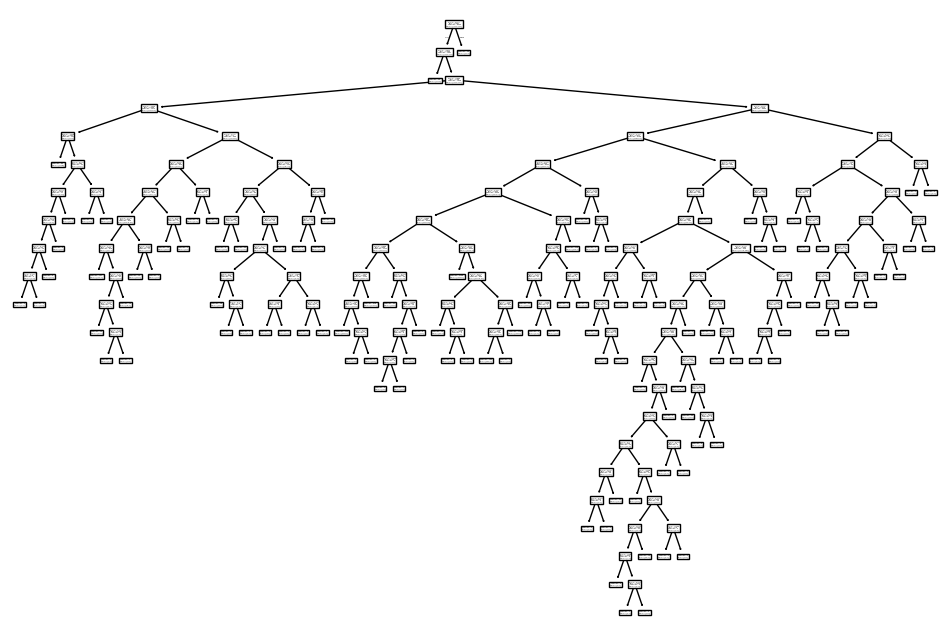

In a tree, there are **nodes, leaves and edges (branches)** that connect the nodes. Nodes here are non-leaf nodes that would continue to split while leaves are terminal nodes that would not split further; thus, with no child.

Let's look into the few hyperparamters that we will tackle on for hyperparamter tuning.

    - max_depth: max number of levels in decision trees (go deeper to fit the training data better, do not go too deep to prevent overfitting)

    - max_features: max number of features considered for splitting a node

    - min_samples_split: min number of data points placed in a node before the node is split (stop spliting if the sample reached minimum in a node, thus prevent overfitting caused by creating branches with very few samples)

    - min_sample_leaf: min number of data points required in a leaf node (prohibit leaf node with samples less than the minimum number)


    - n_estimators: number of trees in the forest (More trees improve performance but make computation more expensive as well)

    - criterion: metric for quality of split (measure of impurity)

        - gini: gini index or gini impurity, it favours large partition and only applies to binary split
$$ Gini = 1 - \Sigma_{i=1} \:(p_i)^2 $$
where $p_i$ = probability of being classified to class i
        
        - entropy: also for consturction of binary trees, the measurement of impurity is computed by the following formula. The comparison of  entropy from before and after a split is called information gain, which is equivalent to how much information is gained when spliting a node at a particular value. 
$$ Entropy = -\Sigma_{i=1} \:p_i \:log_2 \:p_i$$
$$ Information\: gain = entropy_{before} - entropy_{after} $$

    - class_weight: By default, all classes have weight one. In class-imbalance situation, for class weight to assign higher weights to the minority class so that the model pays more attention to patterns of minority class, 'balanced' parameter is applied.

In [74]:
# As our dataset is imbalanced, we use 'balanced' for class_weight.
# The feature size is only 10, so the 'max_feature' shouldn't be reduced much.
# The dataset size is of medium size and not too large. Hence, 'n_estimators' and 'max_depth' should be moderate.
# Based on the sample size also, 'min_samples_split' should be set about 5 and 'min_samples_leaf' should not be too small or too large.
# Therefore, let's experiment the best combination of hyperparameters usung grid search.

params = {
    'n_estimators': [200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8],
    'max_features': [None],
    'class_weight': ['balanced']
}

In [75]:
final_feature = feature_sets['feature 3']
model = RandomForestClassifier()

In [76]:
def preprocess(df, features):
    # Define input and target
    X = df[[feature for feature in features]]
    y = df['Machine failure']

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

In [77]:
X_train, y_train = preprocess(df, final_feature)

In [78]:
# grid search
grid_search = GridSearchCV(model, params, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 50], 'max_features': [None],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300]},
             scoring='f1')

In [82]:
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


### Save final model

In [94]:
# K-Fold
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=58)

In [95]:
model_name = 'Random Forest'
final_model = RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300, class_weight='balanced')
feature_set_name = 'Feature 3'
final_feature = feature_sets['feature 3']

performance = []

X = df[[feature for feature in final_feature]]
y = df['Machine failure']

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

acc_scores, f1_scores, roc_auc_scores, mcc_scores = [], [], [], []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)[:, 1] if hasattr(final_model, "predict_proba") else None
    
    acc_scores.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1_scores.append(f1)
    mcc_scores.append(mcc)

    cprint(f"Fold {fold_idx}/5", "green", attrs=["bold"])
    cprint(f" --------------- f1_score: {f1:.4f} --------- mcc: {mcc:.4f} ---------------", "yellow")

    del y_pred, y_prob

performance.append({
    "Feature Set": feature_set_name,
    "Model": model_name,
    "Accuracy (Mean)": np.mean(acc_scores),
    "Accuracy (Std)": np.std(acc_scores),
    "ROC-AUC (Mean)": np.nanmean(roc_auc_scores),
    "ROC-AUC (Std)": np.nanstd(roc_auc_scores),
    "F1-Score (Mean)": np.mean(f1_scores),
    "F1-Score (Std)": np.std(f1_scores),   
    "MCC (Mean)": np.mean(mcc_scores),
    "MCC (Std)": np.std(mcc_scores),
})

cprint("Average scores across 5 folds:", "blue", attrs=["bold"])
cprint(f" --------------- F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f} ---------------", "yellow")
cprint(f" --------------- MCC:      {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f} ---------------", "yellow")
display(pd.DataFrame(performance))

Fold 1/5
 --------------- f1_score: 0.8750 --------- mcc: 0.8719 ---------------
Fold 2/5
 --------------- f1_score: 0.8235 --------- mcc: 0.8272 ---------------
Fold 3/5
 --------------- f1_score: 0.8372 --------- mcc: 0.8331 ---------------
Fold 4/5
 --------------- f1_score: 0.8525 --------- mcc: 0.8539 ---------------
Fold 5/5
 --------------- f1_score: 0.8000 --------- mcc: 0.8015 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.8376 ± 0.0254 ---------------
 --------------- MCC:      0.8375 ± 0.0240 ---------------


,Feature Set,Model,Accuracy (Mean),Accuracy (Std),ROC-AUC (Mean),ROC-AUC (Std),F1-Score (Mean),F1-Score (Std),MCC (Mean),MCC (Std)
0,Feature 3,Random Forest,0.99,0.001378,0.975648,0.006647,0.83764,0.025422,0.837531,0.023959


In [ ]:
with open(f'{MODEL}/final_PM_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Future improvement

- **Multiclass Classification for Failure Type**\
The dataset also include labels for different types of machine failures. If the dataset collected is larger, there would be chances to develop another multiclass classification model to predict types of failure; thus, assisting the equipment sustaining teams in diagnostics and targeted repairs.

- **Data Pool**\
Continuous data collection is required to develop more robust model that is generalized for real production use case.

- **Feature Enrichment**\
Having more research on environmental and operational variables to include additional features that can improve model's understanding and refine the predictions.

- **Other Techniques to Address Class Imbalance**\
SMOTE (Synthetic Minority Over-sampling Technique) and upsampling can be explored to help model detects minority class failure more accurately.

- **IoT Integration & Real Time Monitoring**\
Consider implementing a comprehesive sensory and monitoring framework for real time capturing of machine and environmental data. Such system facilitates in performing timely inference, as well as continuous learning and model updates. By then, the model could be transitioned to time-series modeling that take into account of timestamp. 
To realize this, investments in IoT devices and data infrastructure are needed to support continuous data flow and real-time processing.